### Install

In [ ]:
#!pip install xgboost
#!pip install sweetviz
#!pip install -U imbalanced-learn

In [42]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
import pickle
from sklearn.model_selection import GridSearchCV
import sweetviz as sv
from xgboost import XGBClassifier as xgb
%matplotlib inline

In [20]:
df = pd.read_csv('dataset/CVD_cleaned.csv')
df_with_BMI = pd.read_csv('dataset/CVD_cleaned.csv')

In [4]:
print(f'Shape: {df.shape}')
df.head()

Shape: (308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

In [21]:
columns_binary = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Arthritis', 'Smoking_History']
df[columns_binary] = df[columns_binary].map({'Yes': 1, 'No': 0}.get)

In [22]:
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0})

In [23]:
label_encoder = LabelEncoder()
df['Age_Category'] = label_encoder.fit_transform(df['Age_Category'])

In [24]:
df = pd.get_dummies(df, columns=['General_Health', 'Checkup', 'Diabetes'])

In [17]:
## BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obesity (Class 1)'
    elif 35 <= bmi < 45:
        return 'Obesity (Class 2)'
    else:
        return 'Obesity (Class 3)'

df['BMI_Category'] = df['BMI'].apply(categorize_bmi)
df_with_BMI['BMI_Category'] = df_with_BMI['BMI'].apply(categorize_bmi)

df.drop(columns=['BMI'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['BMI_Category'])

In [25]:
df.corr()

,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),...,General_Health_Very Good,Checkup_5 or more years ago,Checkup_Never,Checkup_Within the past 2 years,Checkup_Within the past 5 years,Checkup_Within the past year,Diabetes_No,"Diabetes_No, pre-diabetes or borderline diabetes",Diabetes_Yes,"Diabetes_Yes, but female told only during pregnancy"
Exercise,1.000000,-0.096347,-0.003986,-0.054388,-0.084729,-0.124813,-0.059344,-0.122345,0.091618,-0.090144,...,0.137000,0.006994,-0.014107,0.032983,0.026013,-0.041233,0.139342,-0.022874,-0.142398,0.000773
Heart_Disease,-0.096347,1.000000,0.090848,0.092387,0.032526,0.153913,-0.072595,0.229011,0.015780,0.045875,...,-0.101697,-0.043290,-0.009834,-0.056322,-0.048325,0.093346,-0.169569,0.019008,0.181072,-0.015198
Skin_Cancer,-0.003986,0.090848,1.000000,0.150824,-0.013014,0.136178,-0.009678,0.272074,0.006812,-0.028954,...,0.000299,-0.048449,-0.014393,-0.042386,-0.046888,0.084941,-0.035442,0.007497,0.038580,-0.011504
Other_Cancer,-0.054388,0.092387,0.150824,1.000000,0.015892,0.129362,0.042044,0.234459,-0.043459,-0.021132,...,-0.052234,-0.050465,-0.013193,-0.050805,-0.050028,0.094030,-0.066431,0.010742,0.070691,-0.010336
Depression,-0.084729,0.032526,-0.013014,0.015892,1.000000,0.121598,0.141450,-0.103169,-0.091318,0.047936,...,-0.074013,-0.031216,-0.012610,-0.008728,-0.011449,0.030408,-0.053403,0.018278,0.044504,0.021210
Arthritis,-0.124813,0.153913,0.136178,0.129362,0.121598,1.000000,0.100053,0.370997,-0.097789,0.074104,...,-0.087519,-0.090504,-0.025150,-0.082582,-0.088600,0.161605,-0.141405,0.039901,0.140077,-0.011373
Sex,-0.059344,-0.072595,-0.009678,0.042044,0.141450,0.100053,1.000000,0.060232,-0.698167,-0.354019,...,0.008349,-0.089192,-0.030387,-0.018345,-0.048504,0.089565,-0.002767,0.004921,-0.023557,0.089126
Age_Category,-0.122345,0.229011,0.272074,0.234459,-0.103169,0.370997,0.060232,1.000000,-0.120895,-0.062262,...,-0.035703,-0.117962,-0.036829,-0.136143,-0.152306,0.253868,-0.205041,0.051606,0.211519,-0.037140
Height_(cm),0.091618,0.015780,0.006812,-0.043459,-0.091318,-0.097789,-0.698167,-0.120895,1.000000,0.472186,...,0.026405,0.075276,0.015096,0.023739,0.046813,-0.083574,0.038235,-0.021482,-0.013635,-0.068259
Weight_(kg),-0.090144,0.045875,-0.028954,-0.021132,0.047936,0.074104,-0.354019,-0.062262,0.472186,1.000000,...,-0.066361,0.006060,-0.002515,-0.022760,-0.008049,0.019640,-0.167611,0.044591,0.169457,-0.021628


In [26]:
# Identify categorical columns
columns_categorical = ['Age_Category', 'Sex'] + columns_binary
df_categorical = df[columns_categorical]

# Identify dummy variable columns
substrings = ['General_Health', 'Checkup', 'Diabetes']
df_dummy = pd.concat([df.filter(like=sub) for sub in substrings], axis=1)

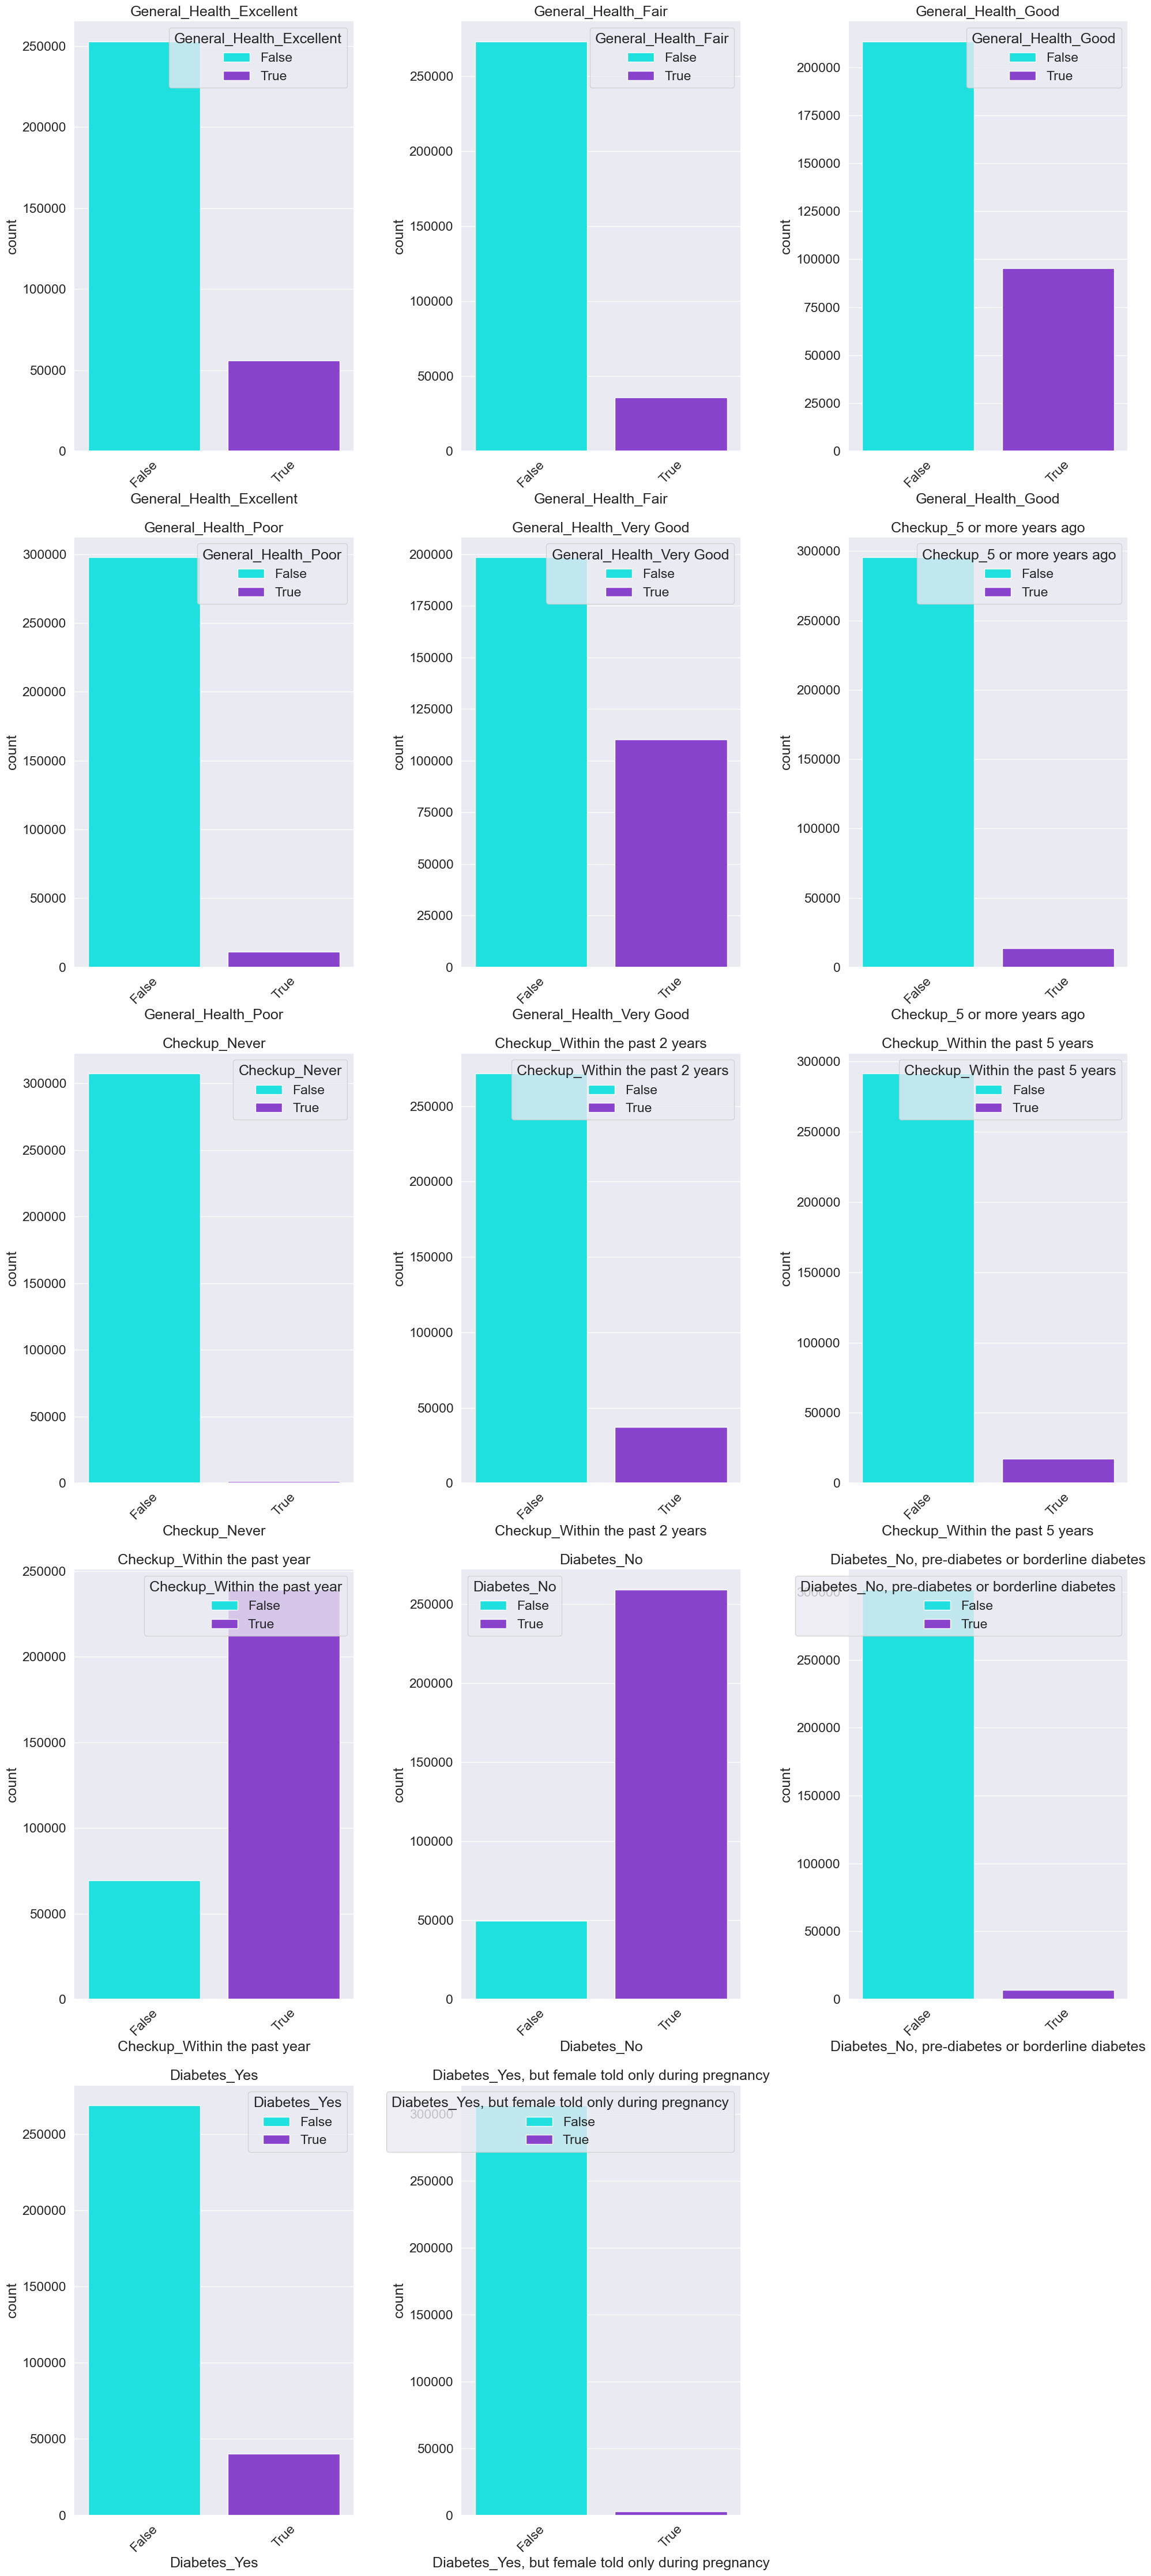

In [33]:
# Plot count plots for df_dummy
a = 5  # number of rows
b = 3  # number of columns
c = 1  # plot counter

fig = plt.figure(figsize=(20, 45))
plt.subplots_adjust(hspace=0.8)
sns.set(font_scale=1.5)

for i in df_dummy.columns:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.countplot(data=df_dummy, x=i, hue=i, palette=['aqua', 'blueviolet'])
    plt.xticks(rotation=45)
    c += 1

fig.tight_layout()
plt.show()

/var/folders/6w/s06kg62j3pld26mvj2zg7cq80000gn/T/ipykernel_23652/462367404.py:14: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df_categorical, x=i, hue=i, palette=['aqua', 'blueviolet'])


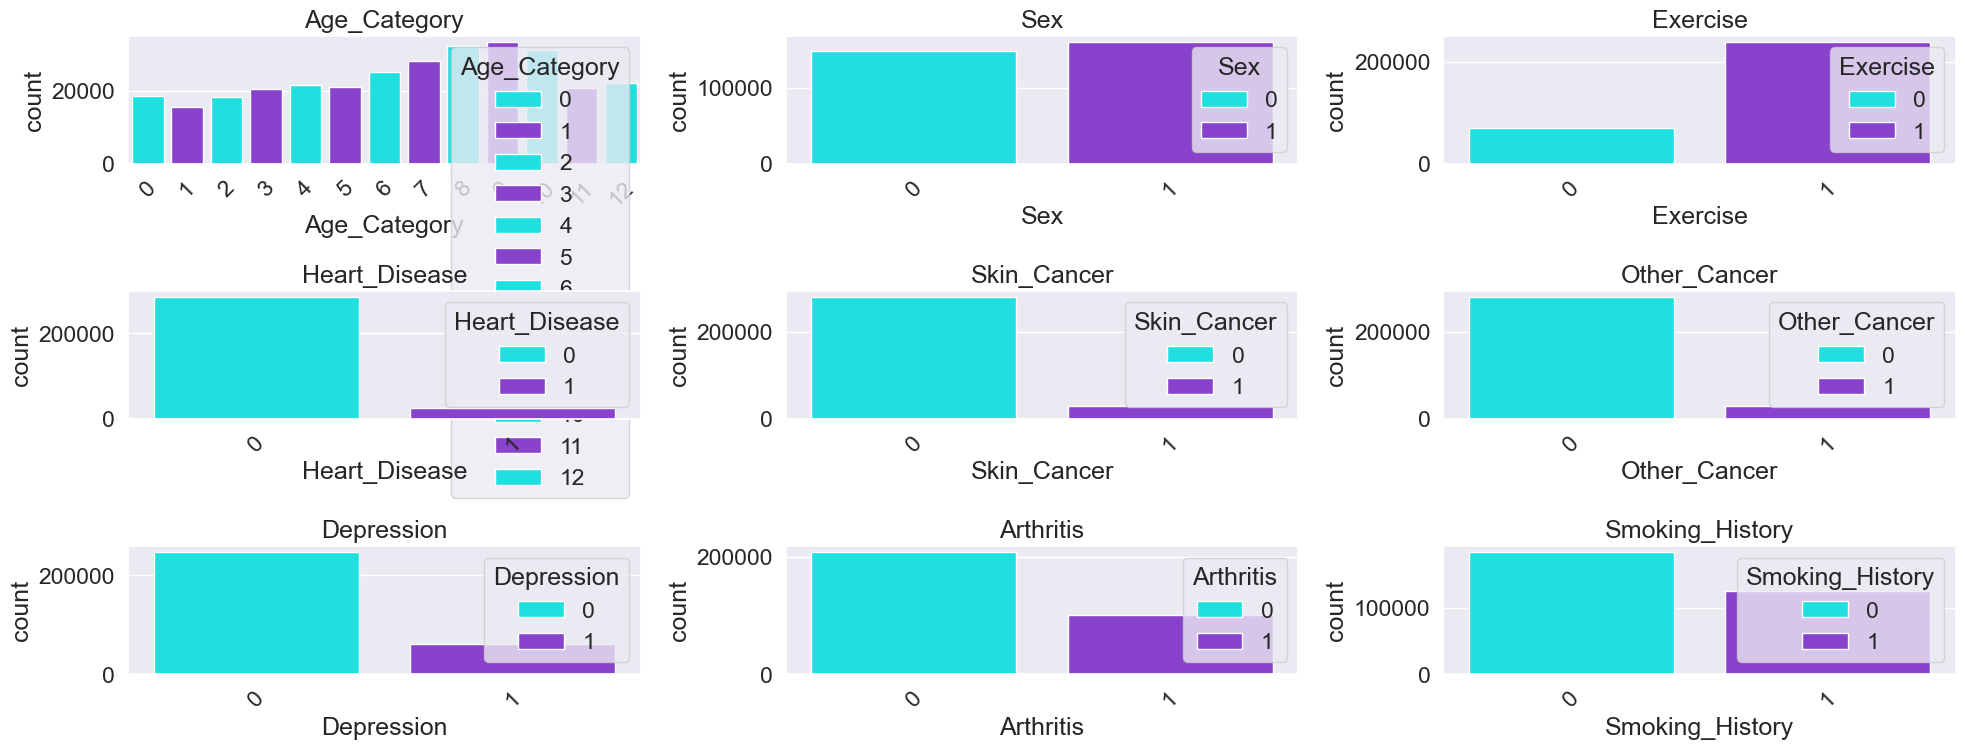

In [34]:
# Plot count plots for df_categorical
a = 5  # number of rows
b = 3  # number of columns
c = 1  # plot counter

fig = plt.figure(figsize=(20, 15))  # Adjust the size if needed
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale=1.5)

for i in df_categorical.columns:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.countplot(data=df_categorical, x=i, hue=i, palette=['aqua', 'blueviolet'])
    plt.xticks(rotation=45)
    c += 1

fig.tight_layout()
plt.show()

<Axes: >

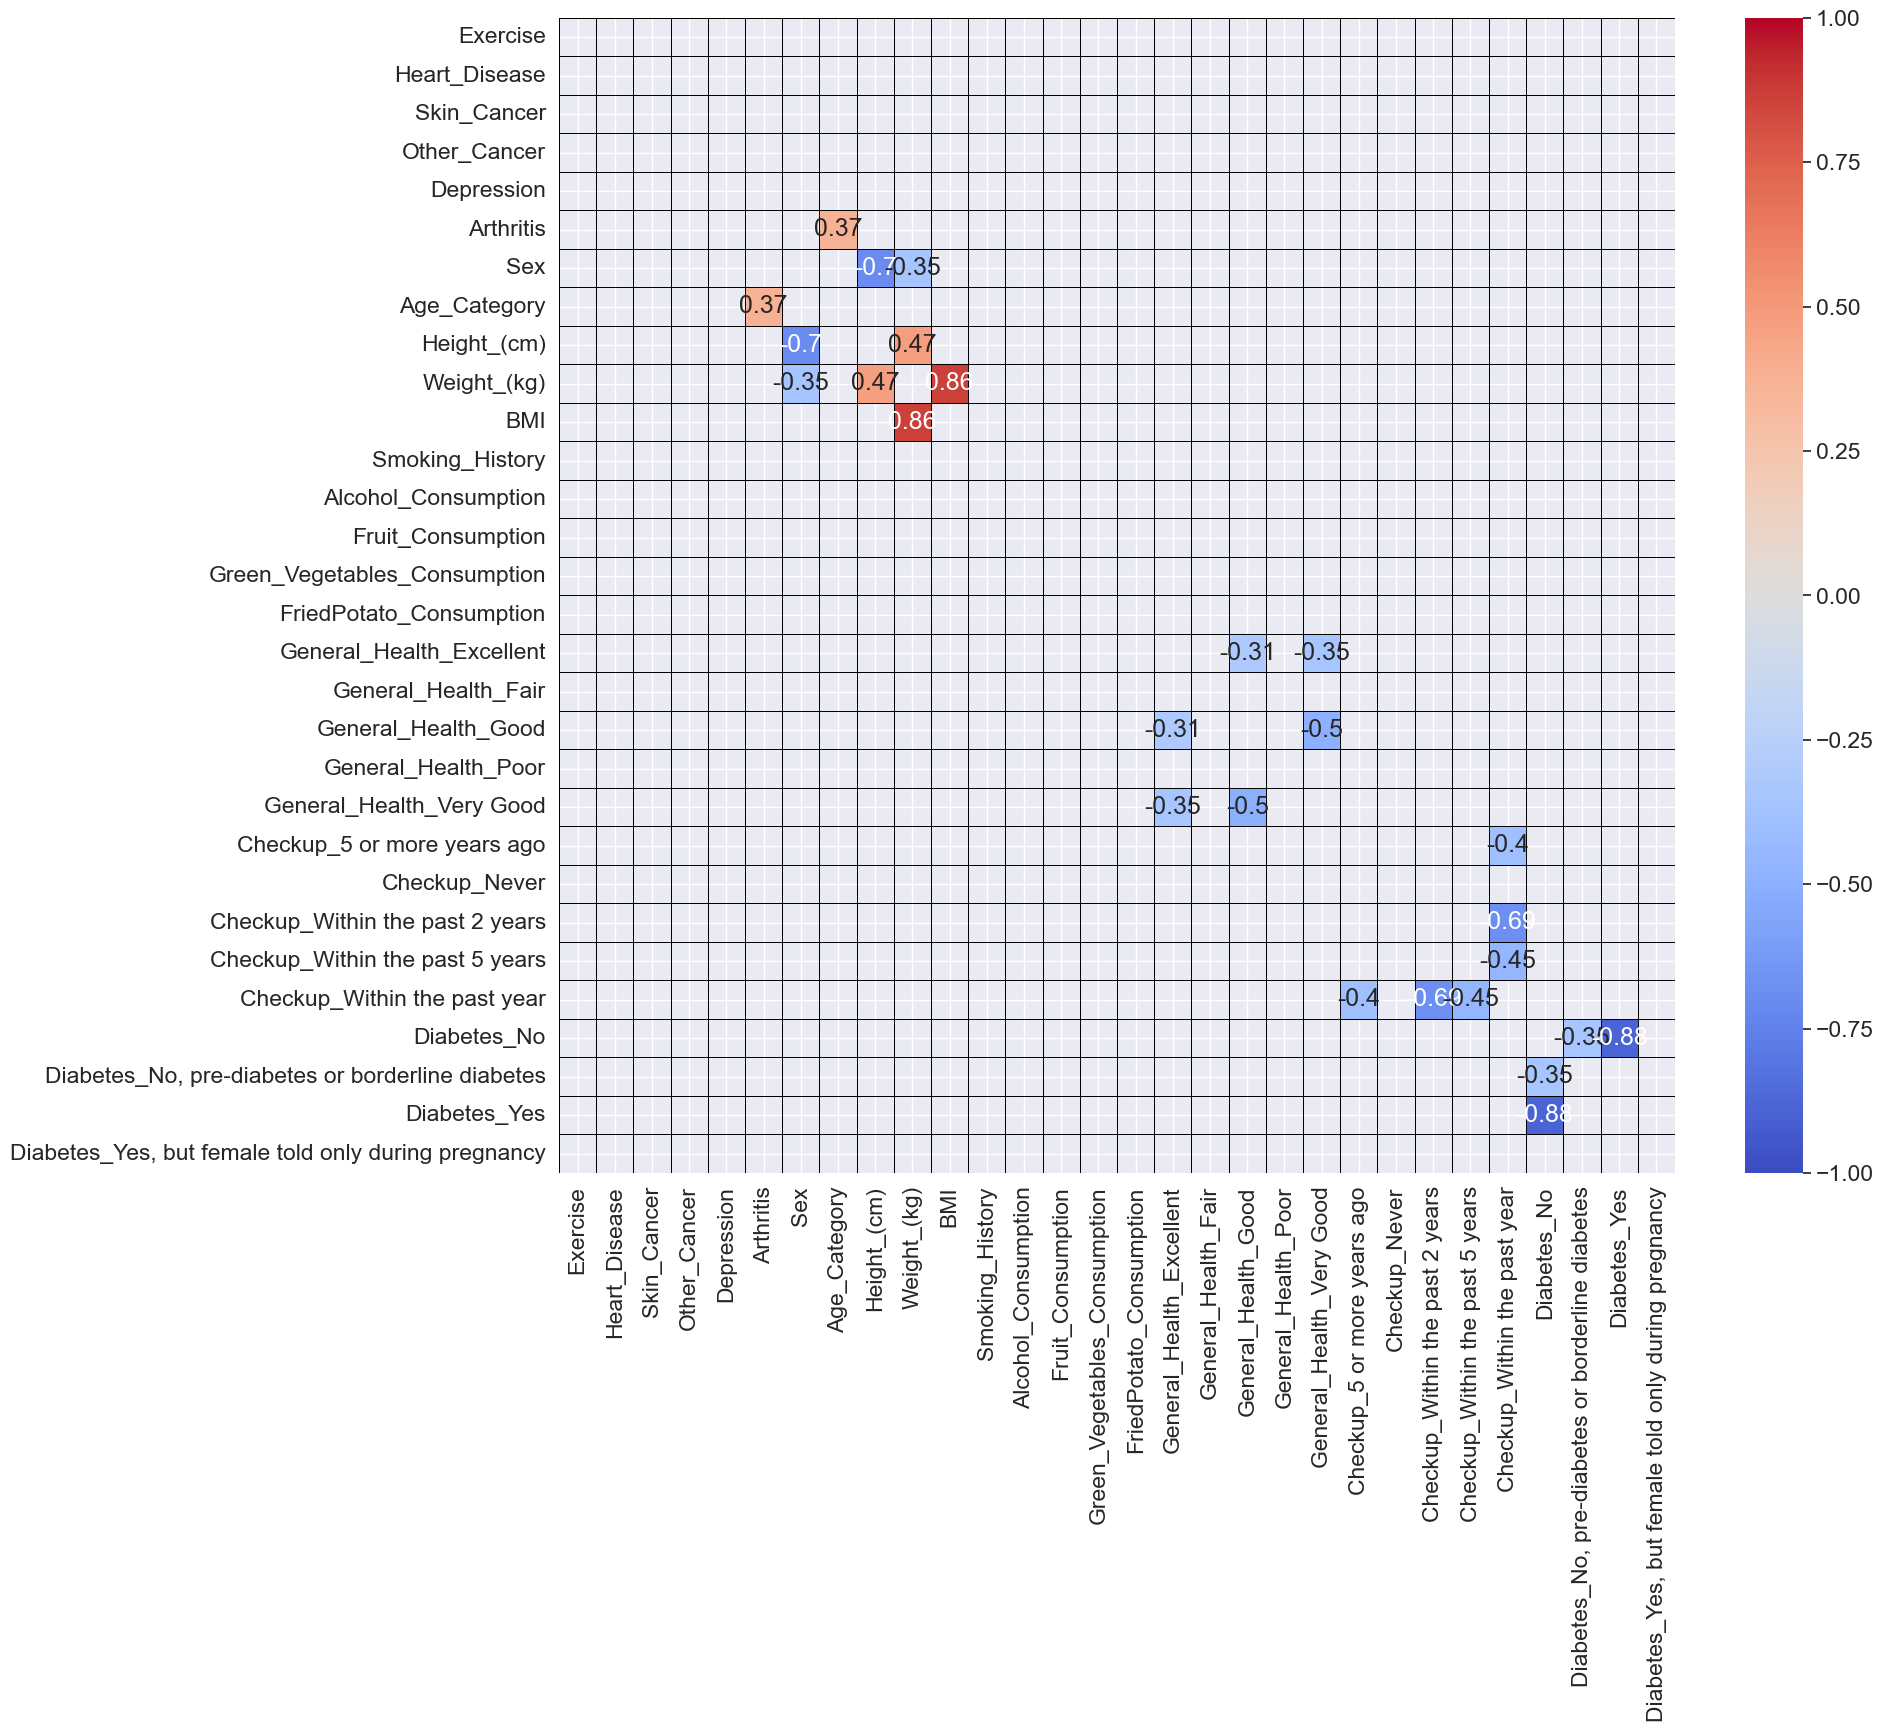

In [35]:
plt.figure(figsize=(18, 15))
correlation_matrix = df.corr()

filtered_correlation = correlation_matrix[
    (correlation_matrix > 0.3) & (correlation_matrix < 1) | (correlation_matrix < -0.3) & (correlation_matrix > -1)
]

sns.heatmap(filtered_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidth=0.5, linecolor='black')

Smoking_History
0    183590
1    125264
Name: count, dtype: int64
Heart_Disease
0    283883
1     24971
Name: count, dtype: int64


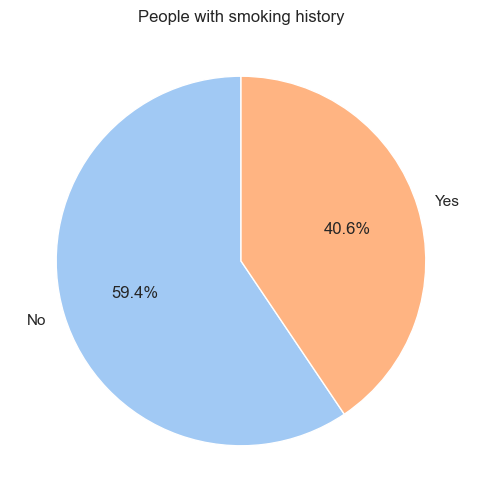

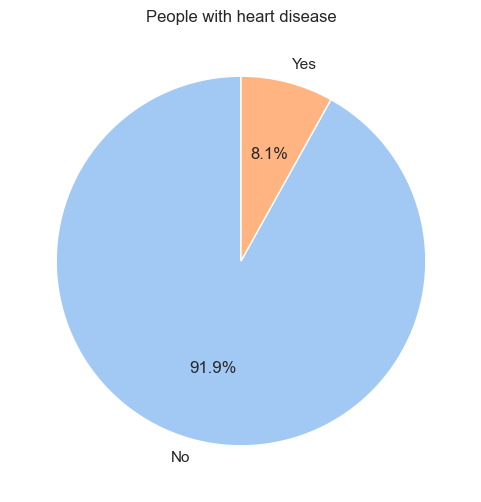

In [36]:
print(df['Smoking_History'].value_counts())
print(df['Heart_Disease'].value_counts())
# Create a pie chart using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.title("People with smoking history")
plt.pie(x=df['Smoking_History'].value_counts(), labels=['No', 'Yes'],  autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.show()
print(f"\n")
plt.figure(figsize=(6, 6))
plt.title("People with heart disease")
plt.pie(x=df['Heart_Disease'].value_counts(), labels=['No', 'Yes'],  autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.show()

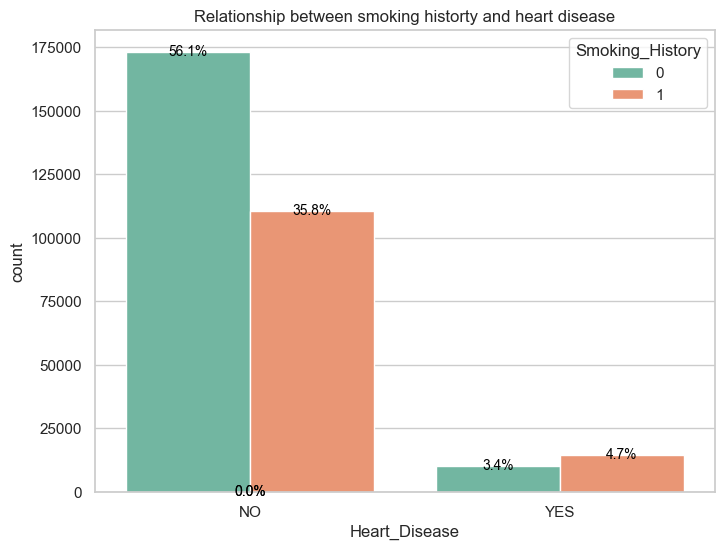

In [37]:
df2 = df.drop(columns=['Weight_(kg)', 'Height_(cm)'])
df2['Smoking_History'] = df['Smoking_History'].map({0: 'NO', 1: 'YES'})
df2['Heart_Disease'] = df['Heart_Disease'].map({0: 'NO', 1: 'YES'})

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df2['Heart_Disease'], hue=df['Smoking_History'], palette="Set2")

plt.title('Relationship between smoking historty and heart disease')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df2))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()

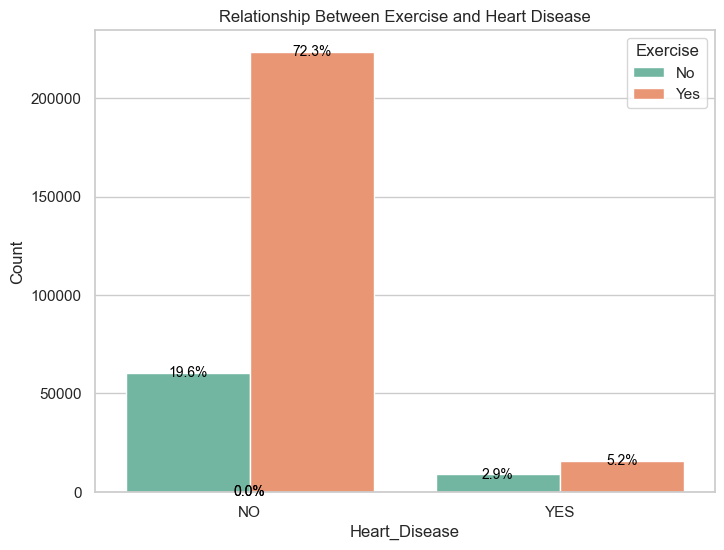

In [38]:
df2['Exercise'] = df['Exercise'].map({1: 'Yes', 0: 'No'})

# Set the style for the plot
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(8, 6))
ax2 = sns.countplot(x="Heart_Disease", hue="Exercise", data=df2, palette="Set2")

# Add labels and title
plt.xlabel("Heart_Disease")
plt.ylabel("Count")
plt.title("Relationship Between Exercise and Heart Disease")

for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df2))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

# Show the plot
plt.show()

## Outliers

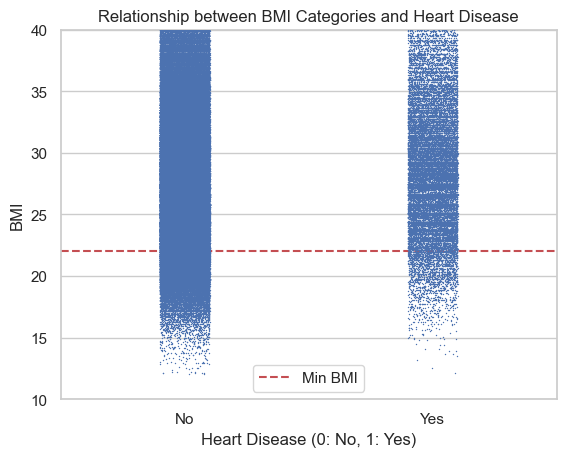

In [39]:
# Strip plot using Seaborn
sns.stripplot(x='Heart_Disease', y='BMI', data=df_with_BMI, jitter=True, s=1, legend="full")
plt.axhline(y=22, color='r', linestyle='--', label='Min BMI')
# Add labels and title
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('BMI')
plt.title('Relationship between BMI Categories and Heart Disease')
# Set the y-axis limits to display a broader range of numbers
plt.ylim(10, 40)

# Show the plot
plt.legend()
plt.show()


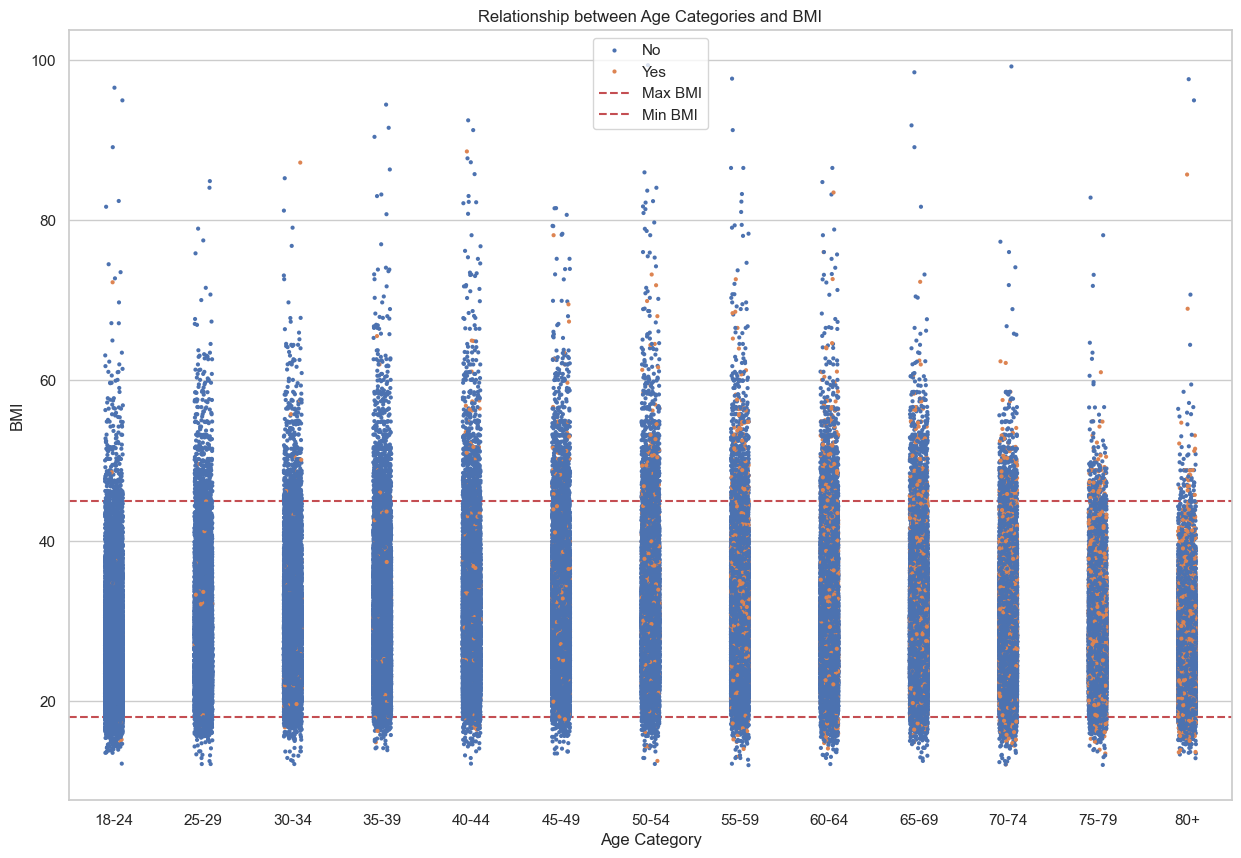

In [40]:
age_cat_sort = sorted(df_with_BMI['Age_Category'].unique())
plt.figure(figsize=(15, 10))
# Strip plot using Seaborn
sns.stripplot(x='Age_Category', y='BMI',hue='Heart_Disease', data=df_with_BMI, jitter=True, size=3, legend="full", order=age_cat_sort)
plt.axhline(y=45, color='r', linestyle='--', label='Max BMI')
plt.axhline(y=18, color='r', linestyle='--', label='Min BMI')

# Add labels and title
plt.xlabel('Age Category')
plt.ylabel('BMI')
plt.title('Relationship between Age Categories and BMI')

# Show the plot
plt.legend()
plt.show()

### Checkup : < 2 years

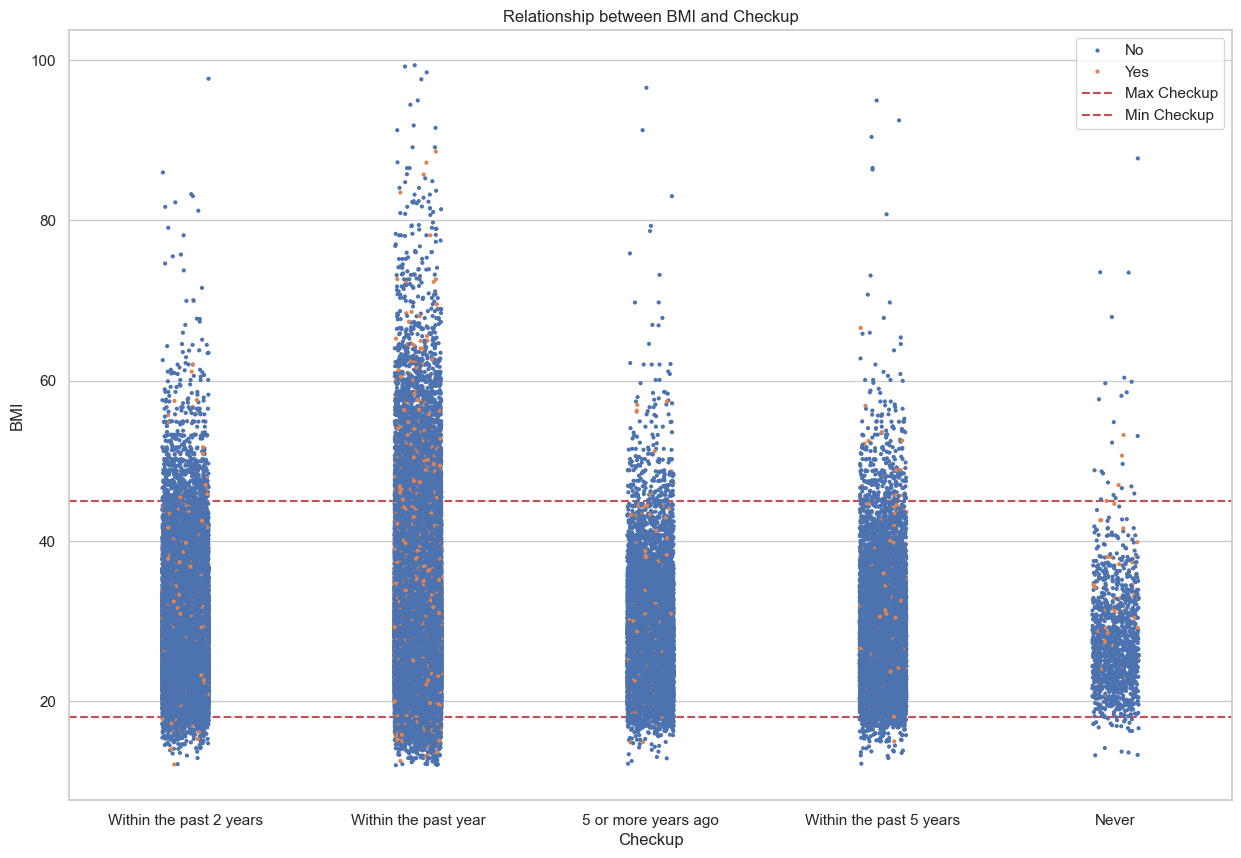

In [41]:
plt.figure(figsize=(15, 10))
# Strip plot using Seaborn
sns.stripplot(x='Checkup', y='BMI',hue='Heart_Disease', data=df_with_BMI, jitter=True, size=3, legend="full")
plt.axhline(y=45, color='r', linestyle='--', label='Max Checkup')
plt.axhline(y=18, color='r', linestyle='--', label='Min Checkup')

# Add labels and title
plt.xlabel('Checkup')
plt.ylabel('BMI')
plt.title('Relationship between BMI and Checkup')

# Show the plot
plt.legend(loc='upper right')
plt.show()

### Model Selection

In [54]:
models = [
    LogisticRegression(max_iter=1000), 
    DecisionTreeClassifier(random_state=40, min_samples_leaf=2), 
    RandomForestClassifier(n_estimators=100, min_samples_leaf=2), 
    AdaBoostClassifier(), 
    GradientBoostingClassifier(), 
    XGBClassifier(base_score=0.3)
]

In [56]:
def sampling(sample_model, X_train=None, y_train=None, test_size: float=.25, random_state: int=42):
    X_res, y_res = sample_model.fit_resample(X_train, y_train)
    return X_res, y_res

In [57]:
def run_models(models, X_train, X_test, y_train, y_test):
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model {type(model).__name__} Accuracy: {accuracy:.2f}")
        
        ## confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(3, 2))
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
        cm_display.plot()
        plt.show()

        ### classification_report
        print(classification_report(y_test, y_pred))
        print('--'*40)

In [58]:
def display_all_models(models: [], X: pd.DataFrame, y: pd.DataFrame, sample: bool=False, sample_models=None, test_size:float=.25, random_state:int=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if sample:
        for sample in sample_models:
            print(f'Sample Name: {type(sample).__name__}')
            X_res, y_res = sampling(sample, X_train=X_train, y_train=y_train)
            run_models(models=models, X_train=X_res, X_test=X_test, y_train=y_res, y_test=y_test)
    else:
        run_models(models, X_train, X_test, y_train, y_test)


In [59]:
X = df.drop('Heart_Disease', axis=1)
y = df['Heart_Disease']

### Pre Imbalanced

Model LogisticRegression Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

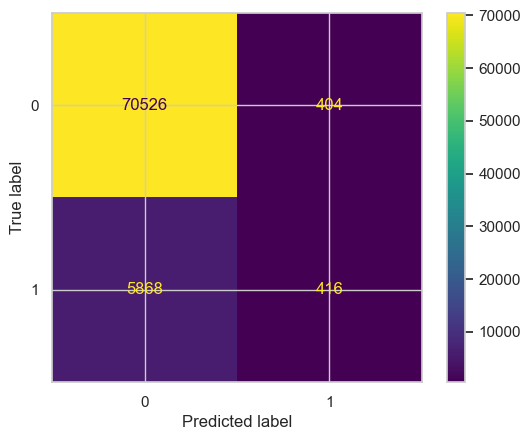

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70930
           1       0.51      0.07      0.12      6284

    accuracy                           0.92     77214
   macro avg       0.72      0.53      0.54     77214
weighted avg       0.89      0.92      0.89     77214

--------------------------------------------------------------------------------
Model DecisionTreeClassifier Accuracy: 0.88


<Figure size 300x200 with 0 Axes>

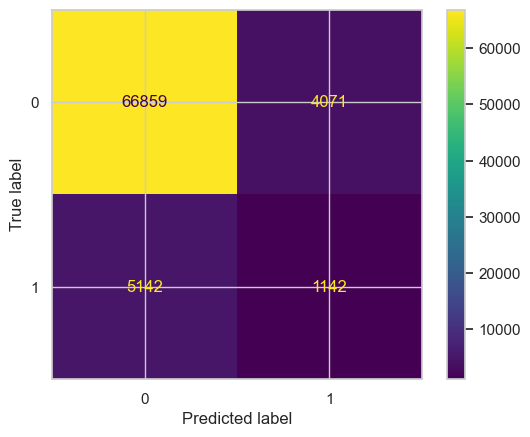

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     70930
           1       0.22      0.18      0.20      6284

    accuracy                           0.88     77214
   macro avg       0.57      0.56      0.57     77214
weighted avg       0.87      0.88      0.88     77214

--------------------------------------------------------------------------------
Model RandomForestClassifier Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

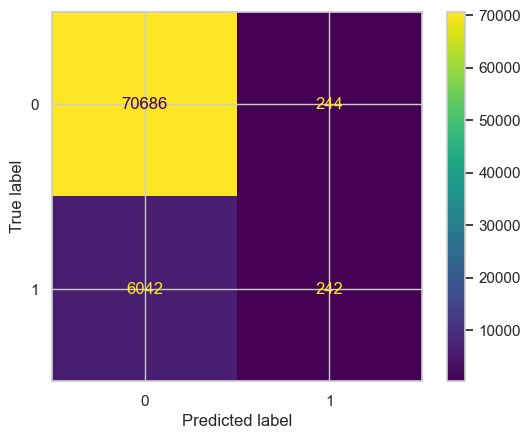

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70930
           1       0.50      0.04      0.07      6284

    accuracy                           0.92     77214
   macro avg       0.71      0.52      0.51     77214
weighted avg       0.89      0.92      0.89     77214

--------------------------------------------------------------------------------
Model AdaBoostClassifier Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

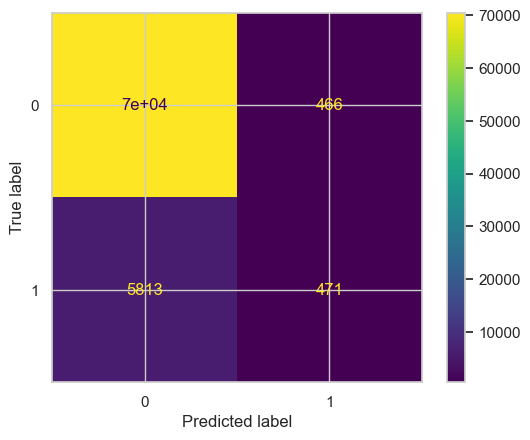

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70930
           1       0.50      0.07      0.13      6284

    accuracy                           0.92     77214
   macro avg       0.71      0.53      0.54     77214
weighted avg       0.89      0.92      0.89     77214

--------------------------------------------------------------------------------
Model GradientBoostingClassifier Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

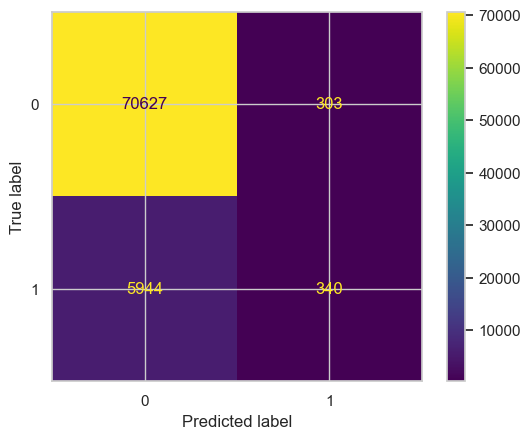

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70930
           1       0.53      0.05      0.10      6284

    accuracy                           0.92     77214
   macro avg       0.73      0.52      0.53     77214
weighted avg       0.89      0.92      0.89     77214

--------------------------------------------------------------------------------
Model XGBClassifier Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

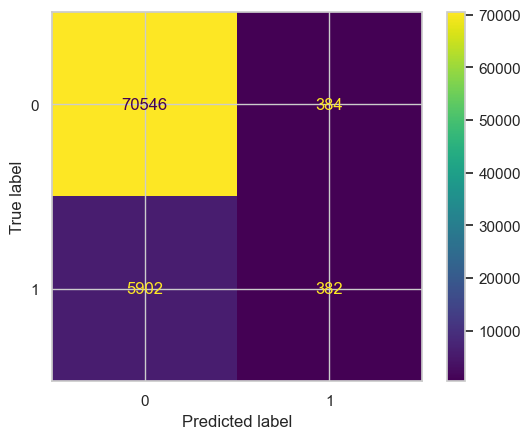

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70930
           1       0.50      0.06      0.11      6284

    accuracy                           0.92     77214
   macro avg       0.71      0.53      0.53     77214
weighted avg       0.89      0.92      0.89     77214

--------------------------------------------------------------------------------


In [55]:
display_all_models(models=models, X=X, y=y)

### Post Imbalanced

In [60]:
sample = [
    RandomOverSampler(),
    RandomUnderSampler(),
    SMOTE(),
    SMOTETomek()
]

Sample Name: RandomOverSampler
Model LogisticRegression Accuracy: 0.74


<Figure size 300x200 with 0 Axes>

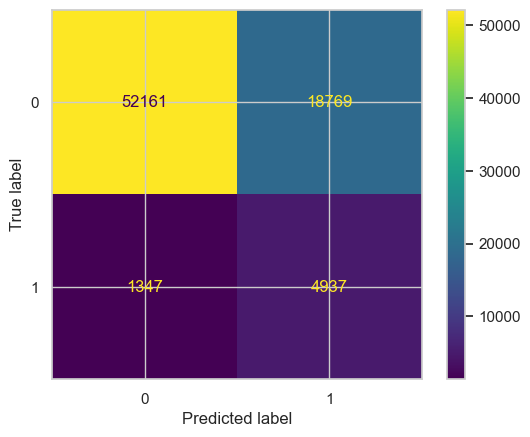

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     70930
           1       0.21      0.79      0.33      6284

    accuracy                           0.74     77214
   macro avg       0.59      0.76      0.58     77214
weighted avg       0.91      0.74      0.80     77214

--------------------------------------------------------------------------------
Model DecisionTreeClassifier Accuracy: 0.86


<Figure size 300x200 with 0 Axes>

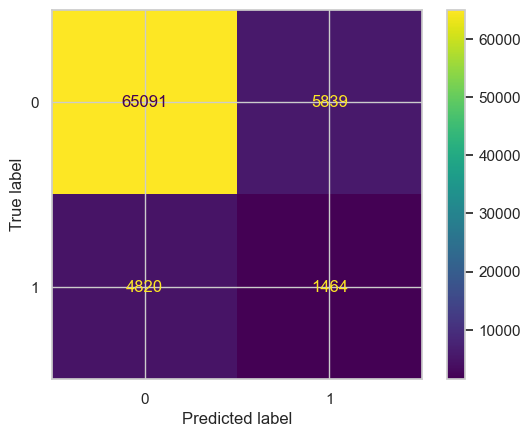

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     70930
           1       0.20      0.23      0.22      6284

    accuracy                           0.86     77214
   macro avg       0.57      0.58      0.57     77214
weighted avg       0.87      0.86      0.87     77214

--------------------------------------------------------------------------------
Model RandomForestClassifier Accuracy: 0.90


<Figure size 300x200 with 0 Axes>

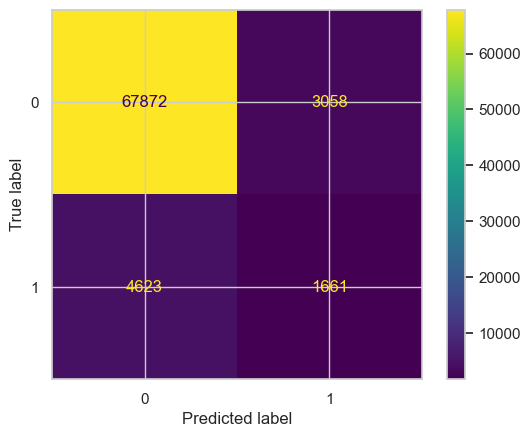

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     70930
           1       0.35      0.26      0.30      6284

    accuracy                           0.90     77214
   macro avg       0.64      0.61      0.62     77214
weighted avg       0.89      0.90      0.89     77214

--------------------------------------------------------------------------------
Model AdaBoostClassifier Accuracy: 0.74


<Figure size 300x200 with 0 Axes>

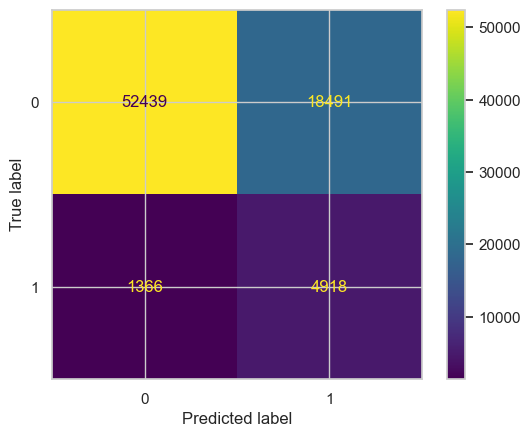

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     70930
           1       0.21      0.78      0.33      6284

    accuracy                           0.74     77214
   macro avg       0.59      0.76      0.59     77214
weighted avg       0.91      0.74      0.80     77214

--------------------------------------------------------------------------------
Model GradientBoostingClassifier Accuracy: 0.73


<Figure size 300x200 with 0 Axes>

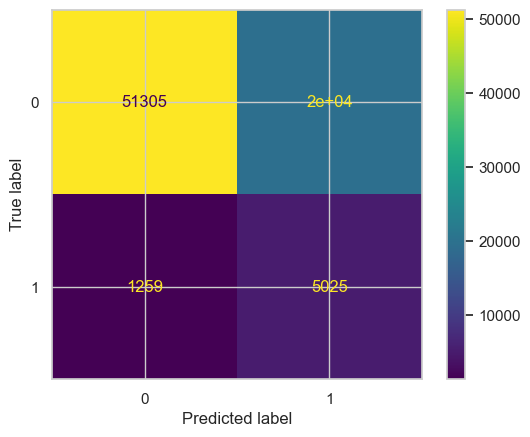

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     70930
           1       0.20      0.80      0.32      6284

    accuracy                           0.73     77214
   macro avg       0.59      0.76      0.58     77214
weighted avg       0.91      0.73      0.79     77214

--------------------------------------------------------------------------------
Model XGBClassifier Accuracy: 0.75


<Figure size 300x200 with 0 Axes>

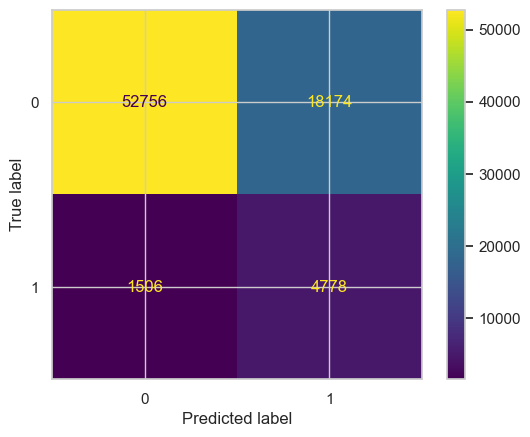

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     70930
           1       0.21      0.76      0.33      6284

    accuracy                           0.75     77214
   macro avg       0.59      0.75      0.58     77214
weighted avg       0.91      0.75      0.80     77214

--------------------------------------------------------------------------------
Sample Name: RandomUnderSampler
Model LogisticRegression Accuracy: 0.74


<Figure size 300x200 with 0 Axes>

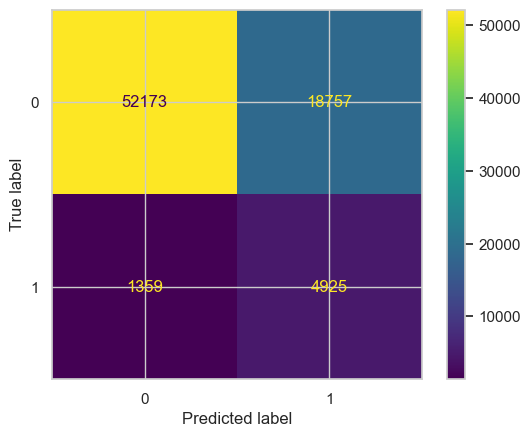

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     70930
           1       0.21      0.78      0.33      6284

    accuracy                           0.74     77214
   macro avg       0.59      0.76      0.58     77214
weighted avg       0.91      0.74      0.80     77214

--------------------------------------------------------------------------------
Model DecisionTreeClassifier Accuracy: 0.70


<Figure size 300x200 with 0 Axes>

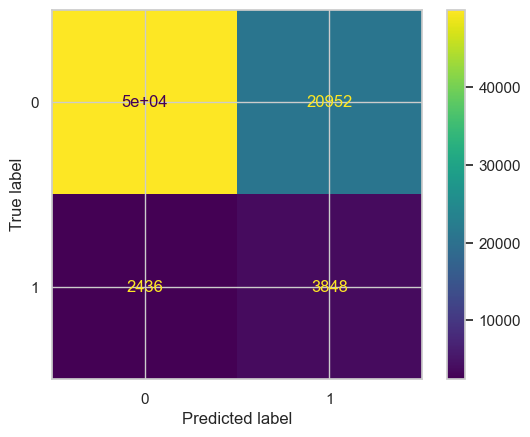

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     70930
           1       0.16      0.61      0.25      6284

    accuracy                           0.70     77214
   macro avg       0.55      0.66      0.53     77214
weighted avg       0.89      0.70      0.76     77214

--------------------------------------------------------------------------------
Model RandomForestClassifier Accuracy: 0.72


<Figure size 300x200 with 0 Axes>

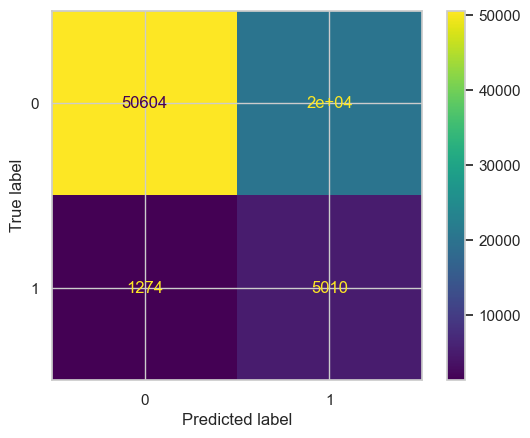

              precision    recall  f1-score   support

           0       0.98      0.71      0.82     70930
           1       0.20      0.80      0.32      6284

    accuracy                           0.72     77214
   macro avg       0.59      0.76      0.57     77214
weighted avg       0.91      0.72      0.78     77214

--------------------------------------------------------------------------------
Model AdaBoostClassifier Accuracy: 0.74


<Figure size 300x200 with 0 Axes>

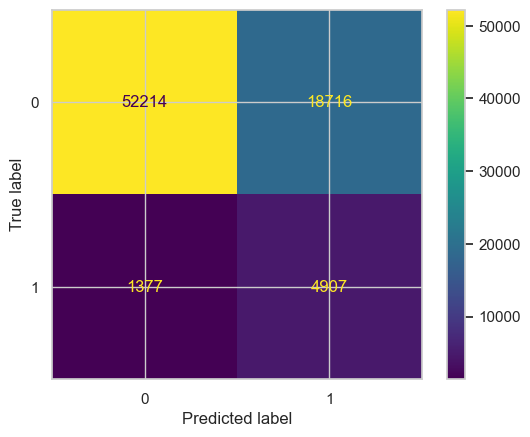

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     70930
           1       0.21      0.78      0.33      6284

    accuracy                           0.74     77214
   macro avg       0.59      0.76      0.58     77214
weighted avg       0.91      0.74      0.80     77214

--------------------------------------------------------------------------------
Model GradientBoostingClassifier Accuracy: 0.73


<Figure size 300x200 with 0 Axes>

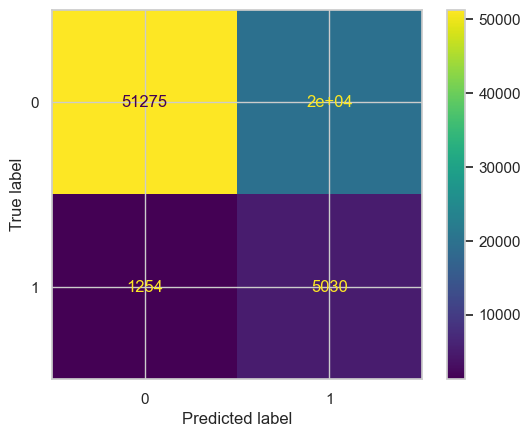

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     70930
           1       0.20      0.80      0.32      6284

    accuracy                           0.73     77214
   macro avg       0.59      0.76      0.58     77214
weighted avg       0.91      0.73      0.79     77214

--------------------------------------------------------------------------------
Model XGBClassifier Accuracy: 0.72


<Figure size 300x200 with 0 Axes>

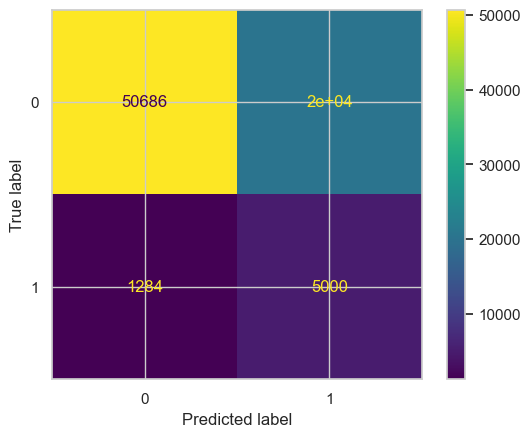

              precision    recall  f1-score   support

           0       0.98      0.71      0.82     70930
           1       0.20      0.80      0.32      6284

    accuracy                           0.72     77214
   macro avg       0.59      0.76      0.57     77214
weighted avg       0.91      0.72      0.78     77214

--------------------------------------------------------------------------------
Sample Name: SMOTE
Model LogisticRegression Accuracy: 0.89


/Users/egorgeller/Desktop/Data_Science/HeartProject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 300x200 with 0 Axes>

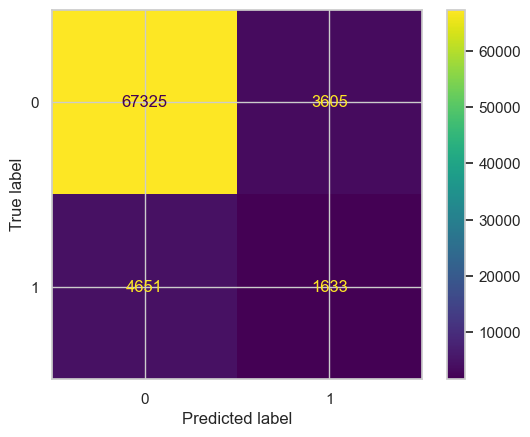

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     70930
           1       0.31      0.26      0.28      6284

    accuracy                           0.89     77214
   macro avg       0.62      0.60      0.61     77214
weighted avg       0.88      0.89      0.89     77214

--------------------------------------------------------------------------------
Model DecisionTreeClassifier Accuracy: 0.87


<Figure size 300x200 with 0 Axes>

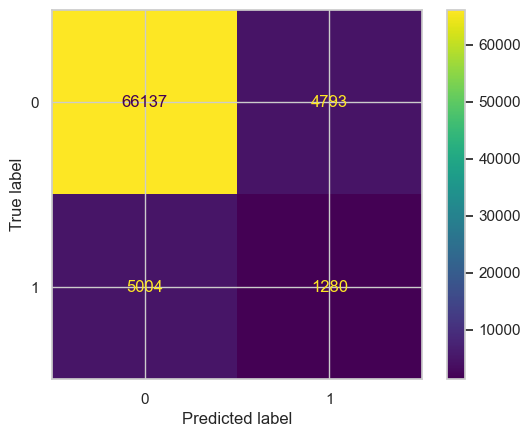

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     70930
           1       0.21      0.20      0.21      6284

    accuracy                           0.87     77214
   macro avg       0.57      0.57      0.57     77214
weighted avg       0.87      0.87      0.87     77214

--------------------------------------------------------------------------------
Model RandomForestClassifier Accuracy: 0.91


<Figure size 300x200 with 0 Axes>

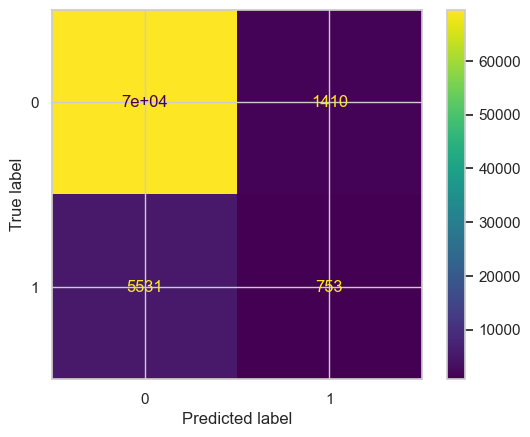

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     70930
           1       0.35      0.12      0.18      6284

    accuracy                           0.91     77214
   macro avg       0.64      0.55      0.57     77214
weighted avg       0.88      0.91      0.89     77214

--------------------------------------------------------------------------------
Model AdaBoostClassifier Accuracy: 0.88


<Figure size 300x200 with 0 Axes>

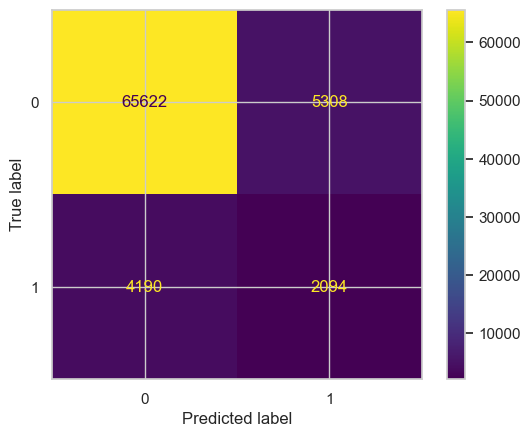

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     70930
           1       0.28      0.33      0.31      6284

    accuracy                           0.88     77214
   macro avg       0.61      0.63      0.62     77214
weighted avg       0.89      0.88      0.88     77214

--------------------------------------------------------------------------------
Model GradientBoostingClassifier Accuracy: 0.89


<Figure size 300x200 with 0 Axes>

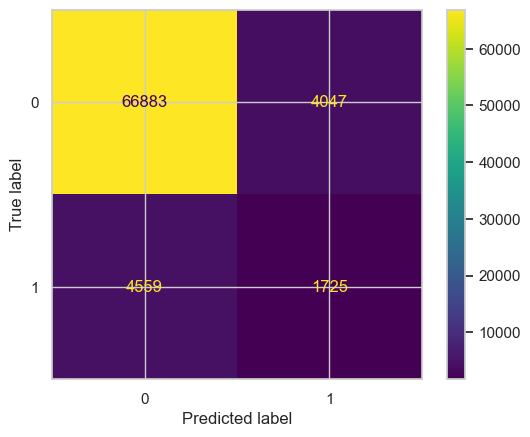

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     70930
           1       0.30      0.27      0.29      6284

    accuracy                           0.89     77214
   macro avg       0.62      0.61      0.61     77214
weighted avg       0.88      0.89      0.89     77214

--------------------------------------------------------------------------------
Model XGBClassifier Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

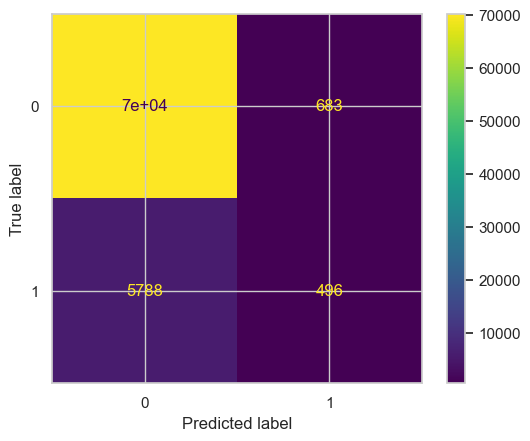

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70930
           1       0.42      0.08      0.13      6284

    accuracy                           0.92     77214
   macro avg       0.67      0.53      0.54     77214
weighted avg       0.88      0.92      0.89     77214

--------------------------------------------------------------------------------
Sample Name: SMOTETomek
Model LogisticRegression Accuracy: 0.89


/Users/egorgeller/Desktop/Data_Science/HeartProject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 300x200 with 0 Axes>

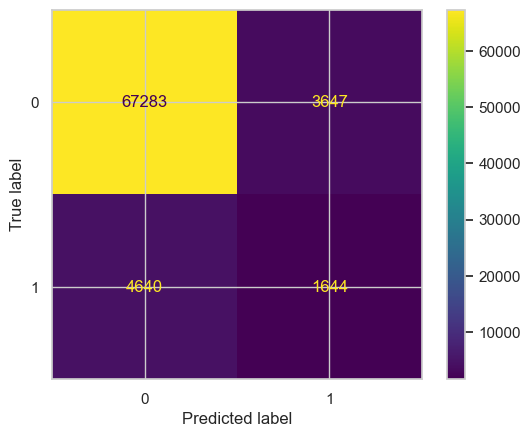

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     70930
           1       0.31      0.26      0.28      6284

    accuracy                           0.89     77214
   macro avg       0.62      0.61      0.61     77214
weighted avg       0.88      0.89      0.89     77214

--------------------------------------------------------------------------------
Model DecisionTreeClassifier Accuracy: 0.87


<Figure size 300x200 with 0 Axes>

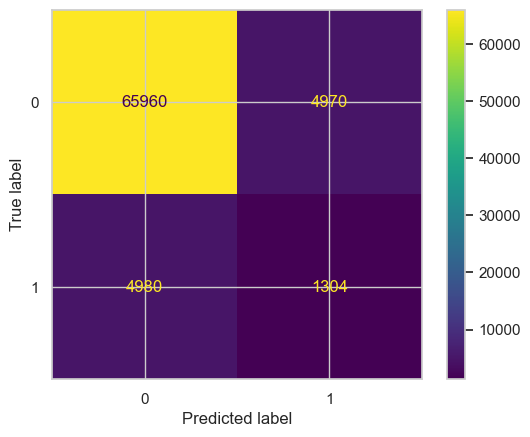

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     70930
           1       0.21      0.21      0.21      6284

    accuracy                           0.87     77214
   macro avg       0.57      0.57      0.57     77214
weighted avg       0.87      0.87      0.87     77214

--------------------------------------------------------------------------------
Model RandomForestClassifier Accuracy: 0.91


<Figure size 300x200 with 0 Axes>

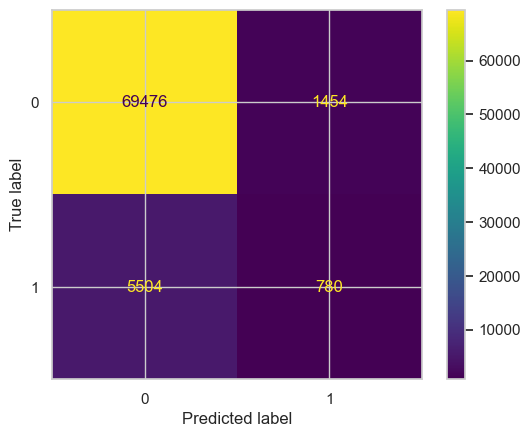

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     70930
           1       0.35      0.12      0.18      6284

    accuracy                           0.91     77214
   macro avg       0.64      0.55      0.57     77214
weighted avg       0.88      0.91      0.89     77214

--------------------------------------------------------------------------------
Model AdaBoostClassifier Accuracy: 0.88


<Figure size 300x200 with 0 Axes>

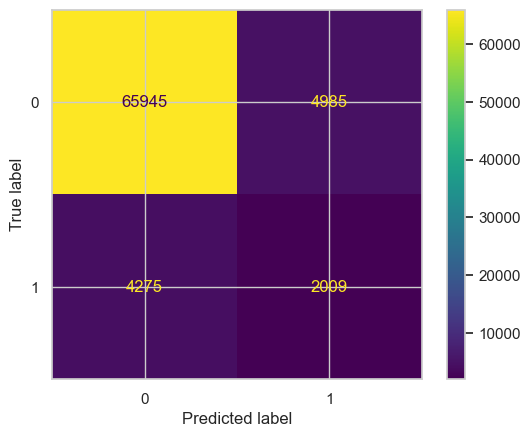

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     70930
           1       0.29      0.32      0.30      6284

    accuracy                           0.88     77214
   macro avg       0.61      0.62      0.62     77214
weighted avg       0.89      0.88      0.88     77214

--------------------------------------------------------------------------------
Model GradientBoostingClassifier Accuracy: 0.89


<Figure size 300x200 with 0 Axes>

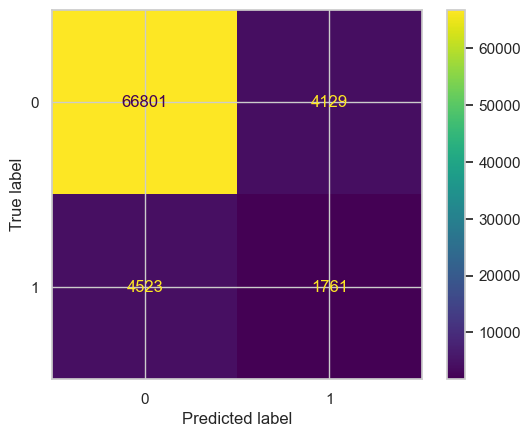

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     70930
           1       0.30      0.28      0.29      6284

    accuracy                           0.89     77214
   macro avg       0.62      0.61      0.61     77214
weighted avg       0.88      0.89      0.89     77214

--------------------------------------------------------------------------------
Model XGBClassifier Accuracy: 0.92


<Figure size 300x200 with 0 Axes>

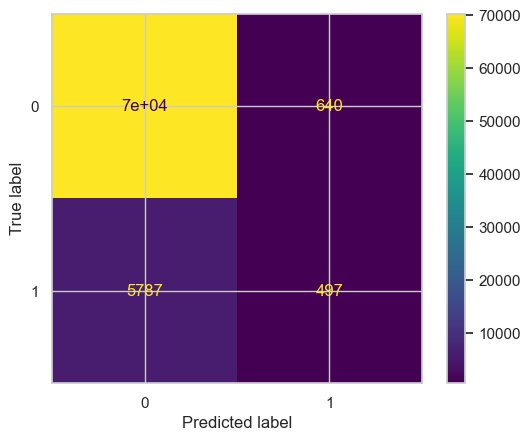

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70930
           1       0.44      0.08      0.13      6284

    accuracy                           0.92     77214
   macro avg       0.68      0.54      0.55     77214
weighted avg       0.88      0.92      0.89     77214

--------------------------------------------------------------------------------


In [61]:
display_all_models(models=models, X=X, y=y, sample=True, sample_models=sample)